In [1]:
import os
import json
import datetime
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2

In [2]:
def create_mask_from_segmentation(segmentation, img_shape):
    """
    Create a mask from segmentation points.

    Args:
        segmentation (list): List of segmentation points.
        img_shape (tuple): Shape of the image.

    Returns:
        numpy.ndarray: Mask as a numpy array.
    """
    mask = np.zeros(img_shape, dtype=np.uint8)
    segmentation_array = np.array(segmentation).reshape(-1, 2)
    vertices = segmentation_array.astype(np.int32).reshape((-1, 1, 2)) # Convert segmentation points to integer vertices for cv2.fillPoly
    cv2.fillPoly(mask, [vertices], 1) # Use cv2.fillPoly to create the mask
    return mask

def plot_image_with_bbox_and_mask(img, bbox, mask):
    """
    Plot the image with bounding box and mask overlay.

    Args:
        img (numpy.ndarray): The image.
        bbox (tuple): Bounding box (x_min, y_min, width, height).
        mask (numpy.ndarray): Mask to overlay.
    """

    # Plot the image with 5 subplots
    fig, ax = plt.subplots(1, 5, figsize=(25, 5))

    # First subplot - Raw Image
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Raw Image')

    # Second subplot - Mask (for visualization)
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Segmentation Mask')

    # Third subplot - Bounding Box & Segmentation (on black background)
    x, y, width, height = bbox
    rect = Rectangle((x-0.5, y-0.5), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax[2].imshow(np.zeros_like(img), cmap='gray')
    ax[2].add_patch(rect)
    ax[2].set_title('Bounding Box')

    # Fourth subplot - Raw Image with Bounding Box
    rect = Rectangle((x-0.5, y-0.5), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax[3].imshow(img, cmap='gray')
    ax[3].add_patch(rect)
    ax[3].set_title('Raw Image with Bounding Box')

    # Fifth subplot - Image with mask overlay
    rect = Rectangle((x-0.5, y-0.5), width, height, linewidth=2, edgecolor='r', facecolor='none')
    mask_overlay = np.zeros_like(img, dtype=np.float32)
    mask_overlay[mask == 1] = 0.3  # Semi-transparent overlay where mask is 1
    ax[4].imshow(img, cmap='gray')  # Base image in grayscale
    ax[4].imshow(np.stack([mask_overlay, mask_overlay*0, mask_overlay*0], axis=2), alpha=0.5)  # Red overlay
    ax[4].add_patch(rect)  # Add bounding box
    ax[4].set_title('Image with Mask Overlay')

    plt.tight_layout()
    plt.show()

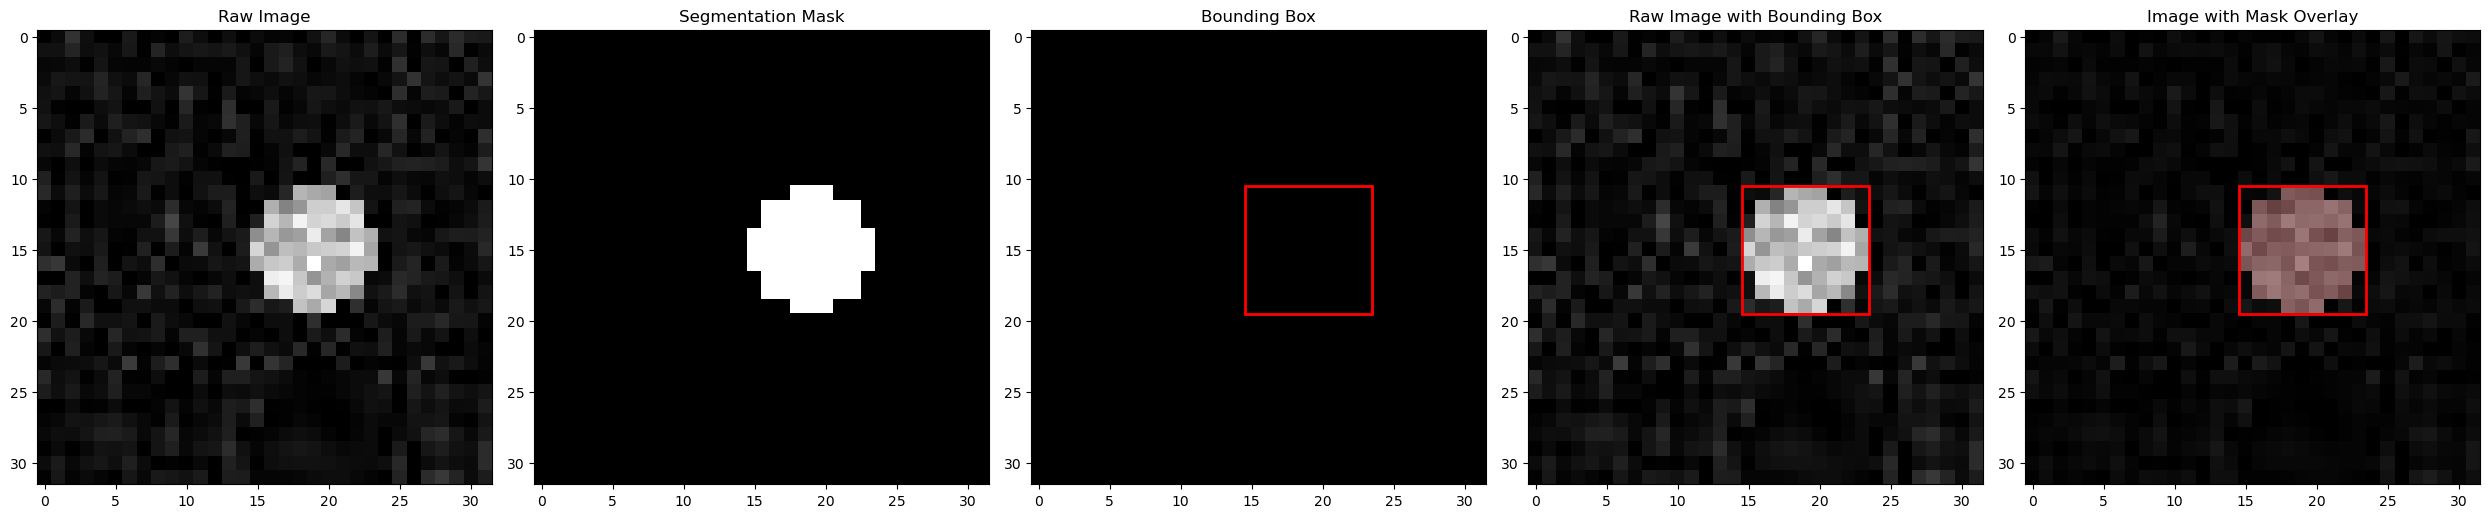

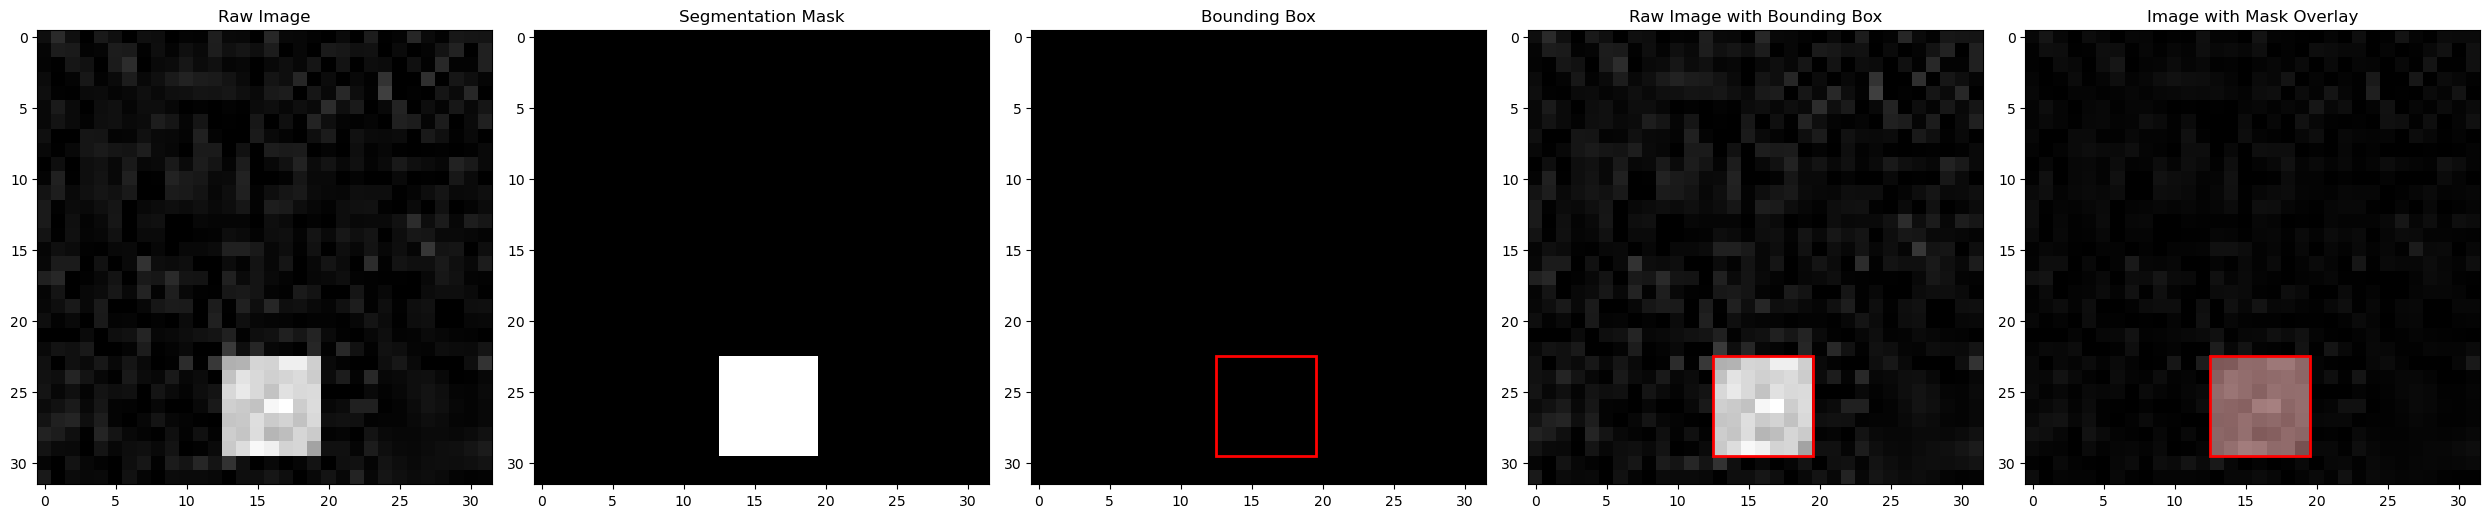

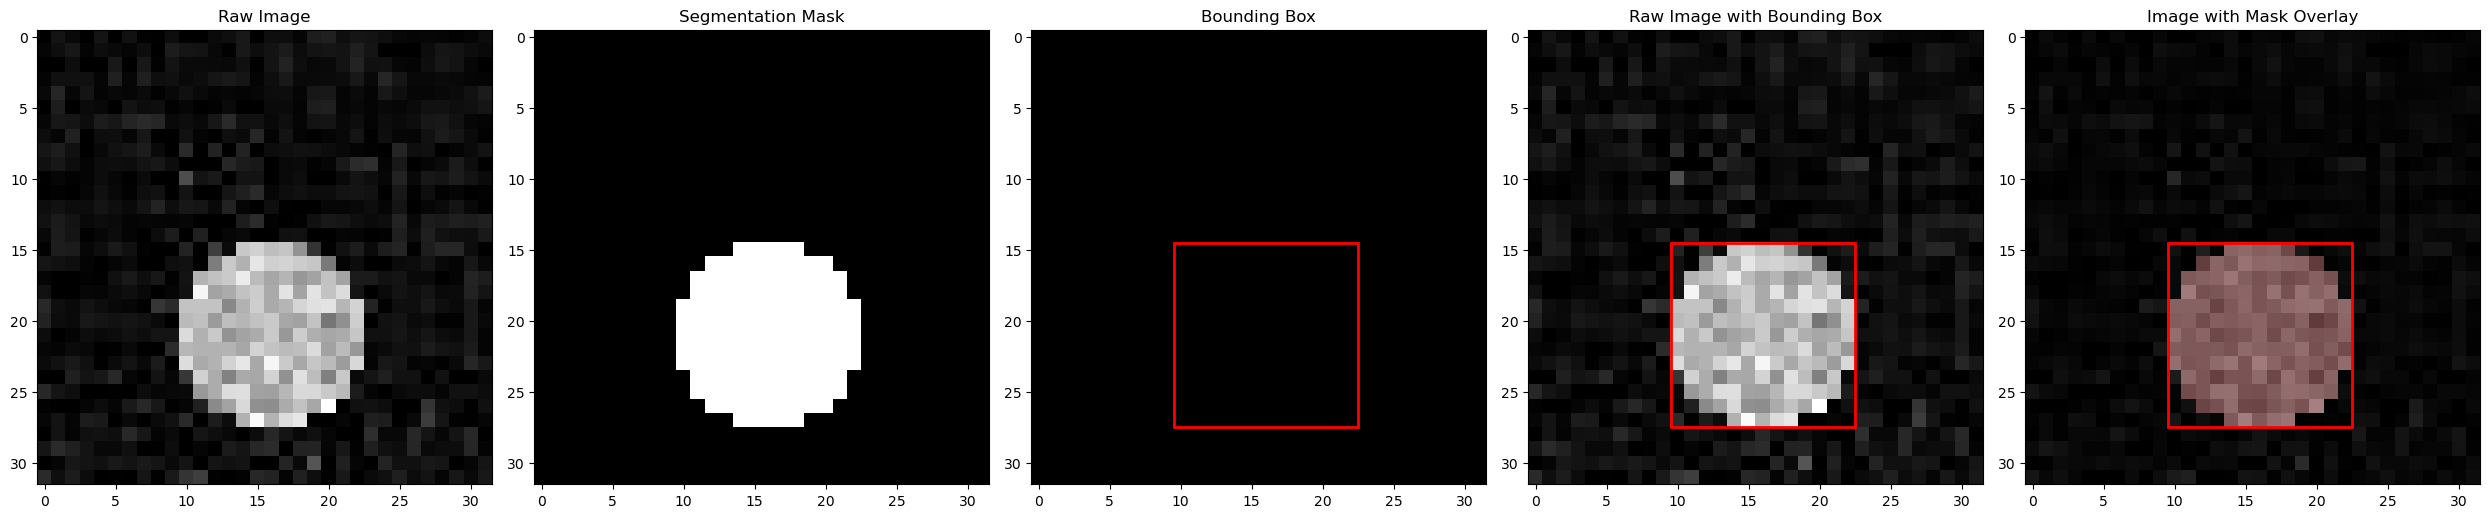

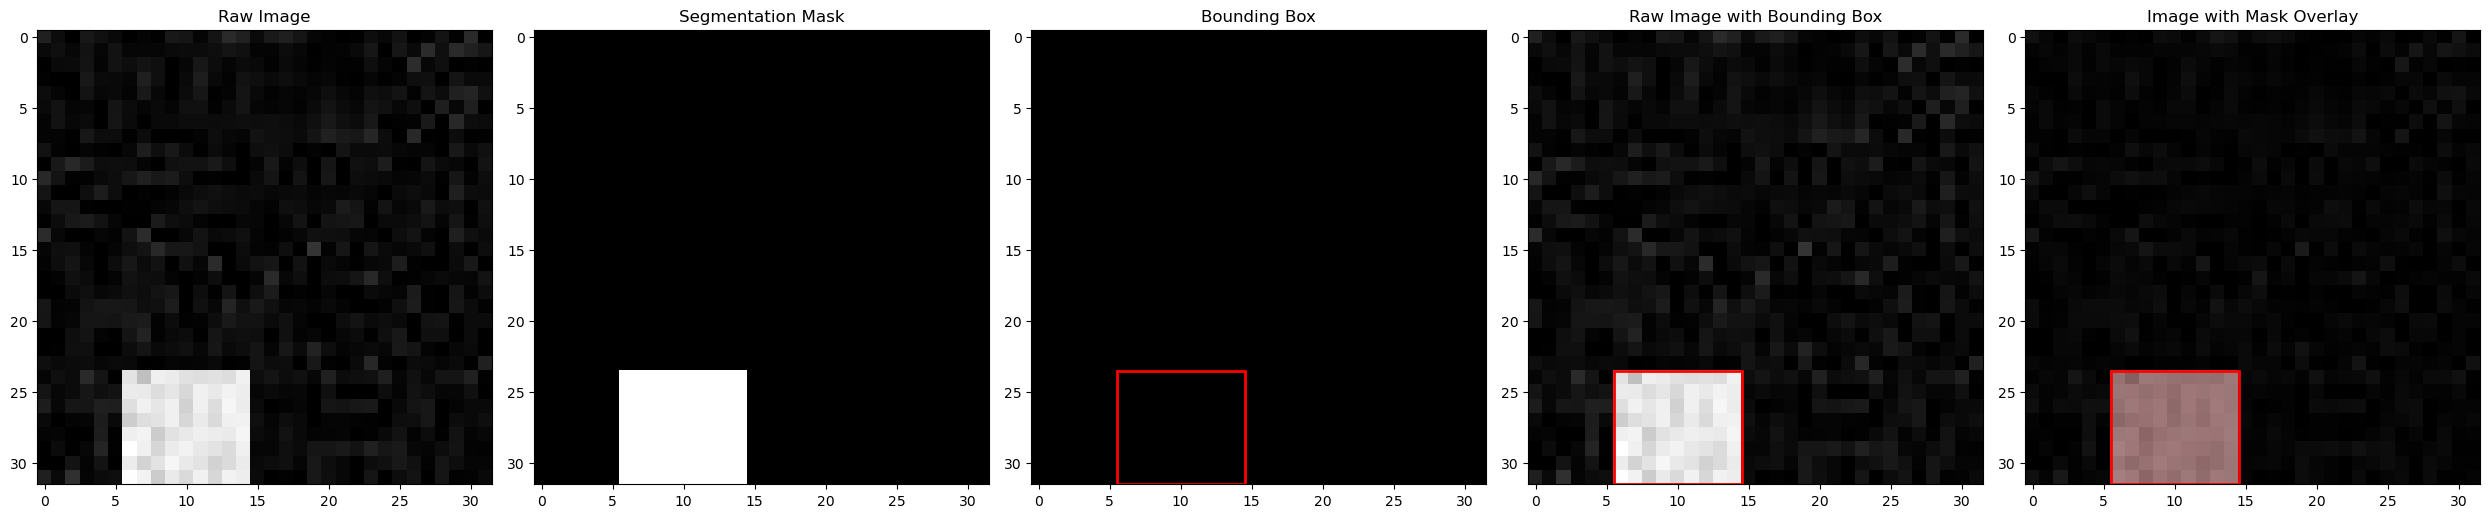

In [3]:
def visualize_coco_data(json_path, img_dir, num_images=5):
    """
    Visualizes COCO data by plotting images with bounding boxes and masks.

    Args:
        json_path (str): Path to the COCO JSON file.
        img_dir (str): Directory containing the images.
        num_images (int): Number of images to visualize.
    """
    # Load the COCO JSON file
    with open(json_path, 'r') as f:
        coco_data = json.load(f)
    
    # Create a dictionary mapping image_id to annotations
    image_to_annotations = {}
    for annotation in coco_data["annotations"]:
        image_id = annotation["image_id"]
        if image_id not in image_to_annotations:
            image_to_annotations[image_id] = []
        image_to_annotations[image_id].append(annotation)
    
    # Process each image
    num_visualized = 0
    for image_info in coco_data["images"]:
        image_id = image_info["id"]
        file_name = image_info["file_name"]
        
        # Skip if no annotations for this image
        if image_id not in image_to_annotations:
            print(f"No annotations found for image {file_name}")
            continue
        
        # Load the image
        img_path = os.path.join(img_dir, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0  # Read image in grayscale and normalize
        
        # Get all annotations for this image
        annotations = image_to_annotations[image_id]
        
        # Plot the image with bounding boxes and masks
        for annotation in annotations:
            bbox = annotation["bbox"]
            segmentation = annotation["segmentation"][0]
            mask = create_mask_from_segmentation(segmentation, img.shape)
            plot_image_with_bbox_and_mask(img, bbox, mask)
        
        num_visualized += 1
        if num_visualized >= num_images:
            break

# Example usage
json_path = "/home/localssk23/SOLOv2_2D/datasets/dummy_2d/imgs/annotations.json"
img_dir = "/home/localssk23/SOLOv2_2D/datasets/dummy_2d/imgs"
visualize_coco_data(json_path, img_dir, num_images=4)
